In [1]:
import os
import re
import random
import gc
import warnings
from math import sqrt
import json
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import cohen_kappa_score, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import ks_2samp

pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.1.final.0
python-bits      : 64
OS               : Windows
OS-release       : 7
machine          : AMD64
processor        : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 0.25.3
numpy            : 1.17.4
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 39.0.1
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.10.2
pandas_datareader: None
bs4              : None
bottleneck       : None
fastparquet      : None
gcsfs            : None
lxml.etree       : None
matplotlib       : 3

In [2]:
def _log(str):
    os.system(f'echo \"{str}\"')
    print(str)

In [3]:
INPUT_ROOT = '../input/data-science-bowl-2019'
JOIN_KEY = ['installation_id', 'game_session', 'title']
TARGET = 'accuracy_group'
FEATURES = {
    'event_id', 
    'game_session', 
    'timestamp', 
    'installation_id', 
    'event_count',
    'event_code', 
    'game_time', 
    'title', 
    'type', 
    'world',
    'event_data'
}
EVENT_CODES = ['2000', '2010', '2020', '2025', '2030', '2035', '2040', '2050', '2060', '2070', '2075', '2080', '2081', '2083', '3010', '3020', '3021', '3110', '3120', '3121', '4010', '4020', '4021', '4022', '4025', '4030', '4031', '4035', '4040', '4045', '4050', '4070', '4080', '4090', '4095', '4100', '4110', '4220', '4230', '4235', '5000', '5010']
SEED = 31

In [4]:
def _init():
    # Characters such as empty strings '' or numpy.inf are considered NA values
    pd.set_option('use_inf_as_na', True)
    pd.set_option('display.max_columns', 999)
    pd.set_option('display.max_rows', 999)
    
    
_init()

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(SEED)

In [6]:
RANDOM_VALUES = []
for _ in range(4000):
    RANDOM_VALUES.append(random.random())
    
_log(f'RANDOM_VALUES={RANDOM_VALUES[:20]}')

RANDOM_VALUES=[0.01227824739797545, 0.11239886108023578, 0.39283736155074256, 0.683864273453267, 0.13869093321463077, 0.11244356285938728, 0.23180235707395025, 0.7575924853950116, 0.1474012209602784, 0.7406551989400061, 0.6621666555152632, 0.13657852434493012, 0.5356617475477887, 0.4477509299372836, 0.41257008317805066, 0.9963436915955056, 0.0931113892655685, 0.02036645837312856, 0.9398019156431335, 0.40294581161091647]


In [7]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk(INPUT_ROOT):
    for filename in filenames:
        _log(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/data-science-bowl-2019\sample_submission.csv
../input/data-science-bowl-2019\test.csv
../input/data-science-bowl-2019\test.csv.zip
../input/data-science-bowl-2019\train.csv
../input/data-science-bowl-2019\train.csv.zip
../input/data-science-bowl-2019\train_labels.csv
../input/data-science-bowl-2019\train_labels.csv.zip


In [8]:
%%time
train_raw = pd.read_csv(f'{INPUT_ROOT}/train.csv', usecols=FEATURES)
train_labels = pd.read_csv(f'{INPUT_ROOT}/train_labels.csv', usecols=JOIN_KEY + [TARGET])
test_raw = pd.read_csv(f'{INPUT_ROOT}/test.csv', usecols=FEATURES)
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 4 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
accuracy_group     17690 non-null int64
dtypes: int64(1), object(3)
memory usage: 552.9+ KB
Wall time: 51 s


# Add labels to train data

In [9]:
def _remove_unlabelled_data(train_raw, train_labels):
    return train_raw[train_raw['installation_id'].isin(train_labels['installation_id'].unique())]


train_raw = _remove_unlabelled_data(train_raw, train_labels)

In [10]:
%%time
def _add_labels(train_raw, train_labels, on):
    return pd.merge(train_raw, train_labels, on=on, how='left')


train_raw = _add_labels(train_raw, train_labels, on=JOIN_KEY)
del train_labels

Wall time: 4.49 s


# Extract event data JSON

In [11]:
def _concat_columns(df1, df2):
    """Concatenate the columns of two pandas dataframes in the order of the operands.
    Both dataframes must have the same number of rows.
    """
    assert len(df1) == len(df2)
    res = pd.concat([df1, df2.reindex(df1.index)], axis=1, join='inner')
    assert len(res) == len(df1)
    return res
    

def _extract_event_data(df, keep_cols, chunk_size=1000000):
    res = pd.DataFrame()
    _len = len(df)
    for i in tqdm(range(0, _len, chunk_size)):
        if i + chunk_size < _len:
            chunk = df[i:i + chunk_size].copy()
        else:
            chunk = df[i:].copy()
        ed = pd.io.json.json_normalize(chunk['event_data'].apply(json.loads)).add_prefix('ed.')
        ed = ed[keep_cols].astype(np.float32)
        chunk = _concat_columns(chunk, ed)
        # sort=False because not all rows have same fields in event_data
        res = pd.concat([res, chunk], ignore_index=True, sort=False)
    # this line is too slow and OOM error!
    #res[keep_cols] = res[keep_cols].fillna(-1).astype(np.float32)
    assert len(df) == len(res)
    return res


keep_cols = ['ed.duration', 'ed.level', 'ed.round', 'ed.correct', 'ed.misses','ed.weight', 'ed.total_duration']
#keep_cols = ['ed.identifier', 'ed.duration', 'ed.level', 'ed.round', 'ed.correct', 'ed.misses','ed.weight', 'ed.total_duration', 'ed.source']
train_raw = _extract_event_data(train_raw, keep_cols)
test_raw = _extract_event_data(test_raw, keep_cols)

100%|████████████████████████████████████████████████████| 2/2 [01:35<00:00, 47.59s/it]


In [12]:
test_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data columns (total 18 columns):
event_id             1156414 non-null object
game_session         1156414 non-null object
timestamp            1156414 non-null object
event_data           1156414 non-null object
installation_id      1156414 non-null object
event_count          1156414 non-null int64
event_code           1156414 non-null int64
game_time            1156414 non-null int64
title                1156414 non-null object
type                 1156414 non-null object
world                1156414 non-null object
ed.duration          336619 non-null float32
ed.level             84208 non-null float32
ed.round             598718 non-null float32
ed.correct           69806 non-null float32
ed.misses            23658 non-null float32
ed.weight            50353 non-null float32
ed.total_duration    170228 non-null float32
dtypes: float32(7), int64(3), object(8)
memory usage: 127.9+ MB


In [13]:
train_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7734558 entries, 0 to 7734557
Data columns (total 19 columns):
event_id             object
game_session         object
timestamp            object
event_data           object
installation_id      object
event_count          int64
event_code           int64
game_time            int64
title                object
type                 object
world                object
accuracy_group       float64
ed.duration          float32
ed.level             float32
ed.round             float32
ed.correct           float32
ed.misses            float32
ed.weight            float32
ed.total_duration    float32
dtypes: float32(7), float64(1), int64(3), object(8)
memory usage: 914.7+ MB


In [14]:
# All event ids in test set also exist in train set
#test_set = set(test_raw['event_id'])
#train_set = set(train_raw['event_id'])
#vs = test_set - train_set
#_log(f'{len(vs)} event_ids exist in test set but not train set.')

In [15]:
EVENT_IDS = sorted(list(set(train_raw['event_id']) | set(test_raw['event_id'])))
_log(f'{len(EVENT_IDS)} EVENT_IDS={EVENT_IDS}')

379 EVENT_IDS=['0086365d', '00c73085', '01ca3a3c', '022b4259', '02a42007', '0330ab6a', '0413e89d', '04df9b66', '05ad839b', '06372577', '070a5291', '08fd73f3', '08ff79ad', '0a08139c', '0ce40006', '0d18d96c', '0d1da71f', '0db6d71d', '119b5b02', '1325467d', '1340b8d7', '1375ccb7', '13f56524', '14de4c5d', '155f62a4', '1575e76c', '15a43e5b', '15ba1109', '15eb4a7d', '15f99afc', '160654fd', '16667cc5', '16dffff1', '17113b36', '19967db1', '1996c610', '1af8be29', '1b54d27f', '1bb5fbdb', '1beb320a', '1c178d24', '1cc7cfca', '1cf54632', '1f19558b', '222660ff', '2230fab4', '250513af', '25fa8af4', '262136f4', '26a5a3dd', '26fd2d99', '27253bdc', '28520915', '28a4eb9a', '28ed704e', '28f975ea', '29a42aea', '29bdd9ba', '29f54413', '2a444e03', '2a512369', '2b058fe3', '2b9272f4', '2c4e6db0', '2dc29e21', '2dcad279', '2ec694de', '2fb91ec1', '30614231', '30df3273', '31973d56', '3323d7e9', '33505eae', '3393b68b', '363c86c9', '363d3849', '36fa3ebe', '37937459', '37c53127', '37db1c2f', '37ee8496', '38074c54', '

In [16]:
TITLES = test_raw['title'].unique()
test_raw['title'].value_counts()

Bottle Filler (Activity)         112223
Scrub-A-Dub                       96619
Chow Time                         93142
Sandcastle Builder (Activity)     82132
Fireworks (Activity)              61032
Bug Measurer (Activity)           59886
Bubble Bath                       55264
Dino Drink                        53989
Dino Dive                         49368
Crystals Rule                     46867
Chicken Balancer (Activity)       45874
All Star Sorting                  45863
Flower Waterer (Activity)         43819
Happy Camel                       39806
Pan Balance                       38649
Watering Hole (Activity)          35367
Air Show                          27119
Egg Dropper (Activity)            25941
Leaf Leader                       25574
Cauldron Filler (Assessment)      23440
Mushroom Sorter (Assessment)      21962
Bird Measurer (Assessment)        20086
Cart Balancer (Assessment)        19235
Chest Sorter (Assessment)         17904
Crystal Caves - Level 2            1450


In [17]:
TYPES = test_raw['type'].unique()
test_raw['type'].value_counts()

Game          572260
Activity      466274
Assessment    102627
Clip           15253
Name: type, dtype: int64

In [18]:
WORLDS = test_raw['world'].unique()
test_raw['world'].value_counts()

MAGMAPEAK       511291
TREETOPCITY     332295
CRYSTALCAVES    311387
NONE              1441
Name: world, dtype: int64

In [19]:
#test_raw['ed.source'].value_counts()

In [20]:
#test_raw['ed.identifier'].value_counts()

In [21]:
vs = sorted(train_raw['event_code'].unique())
_log(f'{len(vs)} train_raw type={vs}')

42 train_raw type=[2000, 2010, 2020, 2025, 2030, 2035, 2040, 2050, 2060, 2070, 2075, 2080, 2081, 2083, 3010, 3020, 3021, 3110, 3120, 3121, 4010, 4020, 4021, 4022, 4025, 4030, 4031, 4035, 4040, 4045, 4050, 4070, 4080, 4090, 4095, 4100, 4110, 4220, 4230, 4235, 5000, 5010]


In [22]:
%%time
_prev = pd.to_datetime(pd.Series(['2019-08-06T05:22:41.147000000'])).astype(np.int64).values[0]
_next = pd.to_datetime(pd.Series(['2019-08-06T05:22:41.147000001'])).astype(np.int64).values[0]
assert _next - _prev == 1


def _transform_timestamp(df):
    vs = pd.to_datetime(df['timestamp'])
    df['timestamp'] = vs
    assert df['timestamp'].notna().all()
    df['timestamp_int'] = vs.astype(np.int64)
    assert df['timestamp_int'].notna().all()


_transform_timestamp(train_raw)
_transform_timestamp(test_raw)

Wall time: 16 s


In [23]:
%%time
def _set_string_type(df, cols):
    df[cols] = df[cols].astype(str)
    return df


cols = ['event_code', 'timestamp']
train_raw = _set_string_type(train_raw, cols=cols)
test_raw = _set_string_type(test_raw, cols=cols)

Wall time: 1min 18s


In [24]:
%%time
def _sort_it(df):
    return df.sort_values(by=['installation_id', 'timestamp'])


#train_raw = _sort_it(train_raw)
#test_raw = _sort_it(test_raw)

Wall time: 0 ns


# Multiple accuracy groups per installation id
In the training set, you are provided the full history of gameplay data. In the test set, we have truncated the history after the start event of a single assessment, chosen randomly, for which you must predict the number of attempts. Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

In [25]:
vs = train_raw[train_raw[TARGET].notna()].groupby('installation_id', as_index=False)[TARGET].nunique()
vs

0       3
1       3
2       1
3       3
4       1
       ..
3609    2
3610    4
3611    2
3612    1
3613    2
Name: accuracy_group, Length: 3614, dtype: int64

# Train-test split not by time
Both train and test sets span the same time period.

In [26]:
#_log(f'train_raw[timestamp] is from {train_raw.timestamp.min()} to {train_raw.timestamp.max()}')
#_log(f'test_raw[timestamp] is from {test_raw.timestamp.min()} to {test_raw.timestamp.max()}')

In [27]:
#vs = train_raw[(train_raw['installation_id'] == '0006a69f') & (train_raw[TARGET].notna())].groupby(['game_session', 'title', TARGET], as_index=False)['timestamp'].max()
#vs = sorted(vs['timestamp'].values) 
#vs

In [28]:
train_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7734558 entries, 0 to 7734557
Data columns (total 20 columns):
event_id             object
game_session         object
timestamp            object
event_data           object
installation_id      object
event_count          int64
event_code           object
game_time            int64
title                object
type                 object
world                object
accuracy_group       float64
ed.duration          float32
ed.level             float32
ed.round             float32
ed.correct           float32
ed.misses            float32
ed.weight            float32
ed.total_duration    float32
timestamp_int        int64
dtypes: float32(7), float64(1), int64(3), object(9)
memory usage: 973.7+ MB


In [29]:
test_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data columns (total 19 columns):
event_id             1156414 non-null object
game_session         1156414 non-null object
timestamp            1156414 non-null object
event_data           1156414 non-null object
installation_id      1156414 non-null object
event_count          1156414 non-null int64
event_code           1156414 non-null object
game_time            1156414 non-null int64
title                1156414 non-null object
type                 1156414 non-null object
world                1156414 non-null object
ed.duration          336619 non-null float32
ed.level             84208 non-null float32
ed.round             598718 non-null float32
ed.correct           69806 non-null float32
ed.misses            23658 non-null float32
ed.weight            50353 non-null float32
ed.total_duration    170228 non-null float32
timestamp_int        1156414 non-null int64
dtypes: float32(7), int64(3), object(9)

# Feature Engineering

In [30]:
def _key(s):
    return re.sub(r'[\W\s]', '', s).lower()


def _timestamp_cutoffs(df, TARGET):
    res = df[df[TARGET].notna()].copy().groupby(['game_session', 'title', TARGET], as_index=False)['timestamp_int'].max()
    res = sorted(res['timestamp_int'].values)
    return res

    
def _target_variable(df, TARGET):
    vs = df[TARGET].copy().dropna().unique()
    assert len(set(vs)) == 1
    return vs[0]
    
    
def _game_session_stats(df, col, titles, types, worlds, suffix):
    """Try median-of-median approach, instead of median-of-max.
    """
    res = {}
    _default = -999999
    # initialize values
    k = f'{col}_gamesession_p50{suffix}'
    res[k] = np.float32([_default])
    for w in worlds:
        for t in types:
            k = f'{col}_gamesession_{_key(w)}_{_key(t)}_p50{suffix}'
            res[k] = np.float32([_default])

    for t in titles:
        k = f'{col}_gamesession_{_key(t)}_p50{suffix}' 
        res[k] = np.float32([_default])

    tmp = df.groupby(['game_session'], as_index=False)[col].median()
    k = f'{col}_gamesession_p50{suffix}'
    if k in res and not tmp[col].isna().all():
        v = tmp[col].median()
        res[k] = np.float32([v])

    if len(worlds) != 0 and len(types) != 0:
        tmp = df.groupby(['game_session', 'world', 'type'], as_index=False)[col].median()
        tmp.dropna(subset=[col], inplace=True)
        tmp = tmp.groupby(['world', 'type'], as_index=False)[col].median()
        for row in tmp.itertuples(index=False):
            k = f'{col}_gamesession_{_key(row[0])}_{_key(row[1])}_p50{suffix}'
            if k in res:
                res[k] = np.float32([row[2]])

    if len(titles) != 0:
        tmp = df.groupby(['game_session', 'title'], as_index=False)[col].median()
        tmp.dropna(subset=[col], inplace=True)
        tmp = tmp.groupby(['title'], as_index=False)[col].median()
        for row in tmp.itertuples(index=False):
            k = f'{col}_gamesession_{_key(row[0])}_p50{suffix}'
            if k in res:
                res[k] = np.float32([row[1]])
    
    #qs = vs.quantile([0.25, 0.5, 0.75], interpolation='lower').to_numpy()    
    return res


def _count(df, col, values, suffix):
    res = {}
    for v in values:
        res[f'{col}_{_key(v)}{suffix}'] = np.int32([0])
    
    if len(values) != 0:
        tmp = df.groupby([col], as_index=False).count()
        for row in tmp.itertuples(index=False):
            res[f'{col}_{_key(row[0])}{suffix}'] = np.int32([row[1]])
    
    return res
    

def _event_id_features(df, event_ids, titles, types, worlds, suffix):
    res = {}
    # initialize counts
    for eid in event_ids:
        res[f'eid_{eid}{suffix}'] = np.int32([0])      
        for w in worlds:
            for t in types:
                res[f'eid_{eid}_{_key(w)}_{_key(t)}{suffix}'] = np.int32([0])
            
        for t in titles:
            res[f'eid_{eid}_{_key(t)}{suffix}'] = np.int32([0])
                      
    tmp = df.groupby(['event_id'], as_index=False).count()
    for row in tmp.itertuples(index=False):
        res[f'eid_{row[0]}{suffix}'] = np.int32([row[1]])
        
    if len(worlds) != 0 and len(types) != 0:
        tmp = df.groupby(['event_id', 'world', 'type'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            k = f'eid_{row[0]}_{_key(row[1])}_{_key(row[2])}{suffix}'
            if k in res:
                res[k] = np.int32([row[3]])

    if len(titles) != 0:
        tmp = df.groupby(['event_id', 'title'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            k = f'eid_{row[0]}_{_key(row[1])}{suffix}'
            if k in res:
                res[k] = np.int32([row[2]])
        
    return res


def _event_code_features(df, event_codes, titles, types, worlds, suffix):
    res = {}
    # initialize counts
    for code in event_codes:
        res[f'event_{code}{suffix}'] = np.int32([0])
        for w in worlds:
            for t in types:
                res[f'event_{code}_{_key(w)}_{_key(t)}{suffix}'] = np.int32([0])
            
        for t in titles:
            res[f'event_{code}_{_key(t)}{suffix}'] = np.int32([0])
        
    tmp = df.groupby(['event_code'], as_index=False).count()
    for row in tmp.itertuples(index=False):
        res[f'event_{row[0]}{suffix}'] = np.int32([row[1]])
        
    if len(worlds) != 0 and len(types) != 0:
        tmp = df.groupby(['event_code', 'world', 'type'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            k = f'event_{row[0]}_{_key(row[1])}_{_key(row[2])}{suffix}'
            if k in res:
                res[k] = np.int32([row[3]])

    if len(titles) != 0:
        tmp = df.groupby(['event_code', 'title'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            k = f'event_{row[0]}_{_key(row[1])}{suffix}'
            if k in res:
                res[k] = np.int32([row[2]])
        
    return res


def _event_data_features(df, suffix):
    res = {}
    res[f'ed_duration{suffix}'] = np.int32(df['ed.duration'].fillna(0).max())
    res[f'ed_total_duration{suffix}'] = np.int32(df['ed.total_duration'].fillna(0).max())
    res[f'ed_level{suffix}'] = np.int32(df['ed.level'].fillna(0).max())
    res[f'ed_round{suffix}'] = np.int32(df['ed.round'].fillna(0).max())
    res[f'ed_correct{suffix}'] = np.int32(df['ed.correct'].fillna(0).max())
    res[f'ed_misses{suffix}'] = np.int32(df['ed.misses'].fillna(0).max())
    res[f'ed_weight{suffix}'] = np.int32(df['ed.weight'].fillna(0).max())
    res[f'ed_source_resources{suffix}'] = np.int32([sum(df['ed.source'] == 'resources')])
    res[f'ed_source_right{suffix}'] = np.int32([sum(df['ed.source'] == 'right')])
    res[f'ed_source_left{suffix}'] = np.int32([sum(df['ed.source'] == 'left')])
    res[f'ed_source_scale{suffix}'] = np.int32([sum(df['ed.source'] == 'scale')])
    res[f'ed_source_middle{suffix}'] = np.int32([sum(df['ed.source'] == 'middle')])
    res[f'ed_source_heaviest{suffix}'] = np.int32([sum(df['ed.source'] == 'Heaviest')])
    res[f'ed_source_heavy{suffix}'] = np.int32([sum(df['ed.source'] == 'Heavy')])
    res[f'ed_source_lightest{suffix}'] = np.int32([sum(df['ed.source'] == 'Lightest')])
    n = 0
    for i in range(1, 13):
        n += sum(df['ed.source'] == str(i))
    res[f'ed_source_numbered{suffix}'] = np.int32([n])
    res[f'ed_id_dot{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Dot_', regex=False))])
    res[f'ed_id_buddy{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Buddy_', regex=False))])
    res[f'ed_id_cleo{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Cleo_', regex=False))])
    res[f'ed_id_mom{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Mom_', regex=False))])
    res[f'ed_id_sid{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('sid_', regex=False))])
    positives = {'Dot_SoCool', 'Dot_GreatJob', 'ohWow', 'wowSoCool', 'thatLooksSoCool', 'tub_success', 
                 'water_success', 'soap_success', 'Dot_Amazing', 'Dot_WhoaSoCool', 'Dot_ThatsIt', 'youDidIt_1305',
                 'SFX_completedtask', 'Cleo_AmazingPowers', 'RIGHTANSWER1', 'Dot_Awesome', 'greatJob_1306', 'YouDidIt',
                 'RIGHTANSWER3', 'RIGHTANSWER2', 'INSTRCOMPLETE', 'AWESOME', 'WayToGoTeam', 'Dot_NiceWorkAllMatch',
                 'GreatFlying', 'WeDidItOneRoundLeft', 'Cleo_AweOfYourSkills', 'Dot_NiceWork'}
    n_pos = 0
    for p in positives:
        n_pos += sum(df['ed.identifier'].str.contains(p, regex=False))
    res[f'ed_id_positive{suffix}'] = np.int32([n_pos])
    negatives = {'Dot_Uhoh', 'Dot_UhOh', 'Dot_NeedTryAgain', 'IncorrectTooHeavy', 'Dot_GoLower', 'Buddy_TryDifferentNest',
                 'Cleo_BowlTooLight', 'Dot_GoHigher', 'Dot_SoLow', 'Dot_SoHigh', 'Dot_WhoopsTooShort', 'IncorrectTooLight',
                 'NOT_THAT_HEAVY', 'Dot_UhOhTooTall', 'ADD_MORE_WEIGHT', 'wrong1', 'tryAgain1', 'Dot_TryWeighingAgain',
                 'Cleo_RememberHeavierBowl', 'Dot_Whoops', 'Dot_NotBalanced', 'Mom_TooManyContainers',
                 'WrongOver', 'Mom_TooMuchWater', 'Dot_ThatBucketNotRight', 'Dot_TryAgain', 'wrongFewer', 'WrongBetweenCliff',
                 'Mom_NeedMoreContainers', 'Dot_Try', 'Dot_HmTooSmall'}
    n_neg = 1
    for ne in negatives:
        n_neg += sum(df['ed.identifier'].str.contains(ne, regex=False))
    res[f'ed_id_negative{suffix}'] = np.int32([n_neg])
    res[f'ed_id_positive_ratio{suffix}'] = np.float32([n_pos / n_neg])
    return res
    
    
def _worlds_picked():
    return ['MAGMAPEAK', 'TREETOPCITY', 'CRYSTALCAVES']


def _titles_picked():
    return ['Cauldron Filler (Assessment)', 'Mushroom Sorter (Assessment)', 'Bird Measurer (Assessment)',
            'Cart Balancer (Assessment)', 'Chest Sorter (Assessment)'
           ]
    

def _types_picked():
    return ['Assessment', 'Game']
    
        
def _features_map(df, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, suffix=''):
    res = {}
    worlds = _worlds_picked()
    titles = _titles_picked()
    types = _types_picked()
    cols = ['game_time', 'event_count', 'ed.duration', 'ed.level', 'ed.round',
            'ed.correct','ed.misses','ed.weight','ed.total_duration']
    for col in cols:
        res.update(_game_session_stats(df, col, titles=titles, types=types, worlds=worlds, suffix=suffix))
    
    res.update(_count(df, col='type', values=TYPES, suffix=suffix))
    res.update(_count(df, col='world', values=WORLDS, suffix=suffix))
    res.update(_count(df, col='title', values=TITLES, suffix=suffix))
    res.update(_event_code_features(df, EVENT_CODES, titles=titles, types=types, worlds=worlds, suffix=suffix))
    res.update(_event_id_features(df, EVENT_IDS, titles=titles, types=types, worlds=worlds, suffix=suffix))
    #res.update(_event_data_features(df, suffix))
    return res


def _features(df, installation_id, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS):
    res = {}
    if TARGET in df.columns:
        res[TARGET] = np.int16([_target_variable(df, TARGET)])
    res['installation_id'] = [installation_id]    
    res.update(_features_map(df, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS))
    return pd.DataFrame.from_dict(res)


def _preprocess(raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS):
    res = pd.DataFrame()
    raw = raw.set_index('installation_id', drop=False)
    iids = raw['installation_id'].unique()
    prev_len = None
    prev_cols = None
    rv = 0
    for iid in tqdm(iids):
        whole = raw.loc[[iid]].copy()  # double square brackets return a Dataframe!
        whole = whole.set_index('timestamp_int', drop=False)
        dfs = []
        if TARGET in whole.columns:
            # train set: each installation id may contribute one or more examples.
            _prev = pd.to_datetime(pd.Series(['1999-01-01T05:22:41.147000000'])).astype(np.int64).values[0]
            for _curr in _timestamp_cutoffs(whole, TARGET):
                df = whole.loc[_prev + 1:_curr]
                dfs.append(df)
                _prev = _curr
        else:
            # test set: each installation id contributes one example.
            dfs.append(whole)
        j = -1
        if len(dfs) > 1:
            j = int(RANDOM_VALUES[rv])
            rv += 1
        for i, df in enumerate(dfs):
            if TARGET in df.columns:
                installation_id = f'{iid}_{i + 1}'
            else:
                installation_id = iid
            ex = _features(df, installation_id, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS)
            if TARGET in df.columns:
                if i == j:
                    ex['_is_val'] = 0  # validation set
                else:
                    ex['_is_val'] = -1
            prev_len = len(ex.columns) if prev_len is None else prev_len
            prev_cols = set(ex.columns) if prev_cols is None else prev_cols
            if len(ex.columns) != prev_len:
                _diff = set(ex.columns) - prev_cols
                raise ValueError(f'Number of columns must be the same. Difference found={_diff}')
            prev_len = len(ex.columns)
            res = pd.concat([res, ex], ignore_index=True)
    return res



In [31]:
# budget of 4 seconds per iteration
train = _preprocess(train_raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS)

100%|████████████████████████████████████████████| 3614/3614 [2:58:53<00:00,  2.97s/it]


In [32]:
train.info(max_cols=9999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 5215 columns):
accuracy_group                                                17690 non-null int16
installation_id                                               17690 non-null object
game_time_gamesession_p50                                     17690 non-null float32
game_time_gamesession_magmapeak_assessment_p50                17690 non-null float32
game_time_gamesession_magmapeak_game_p50                      17690 non-null float32
game_time_gamesession_treetopcity_assessment_p50              17690 non-null float32
game_time_gamesession_treetopcity_game_p50                    17690 non-null float32
game_time_gamesession_crystalcaves_assessment_p50             17690 non-null float32
game_time_gamesession_crystalcaves_game_p50                   17690 non-null float32
game_time_gamesession_cauldronfillerassessment_p50            17690 non-null float32
game_time_gamesession_mushroomsorterassess

In [33]:
assert train.notna().all(axis=None)
tmp = train.groupby(['_is_val'], as_index=False)['installation_id'].count()
assert tmp.iloc[1]['installation_id'] >= 2000
tmp.head()

_is_val  installation_id
0       -1            15103
1        0             2587

In [34]:
del train_raw, tmp
gc.collect()
train.head(10)

accuracy_group installation_id  game_time_gamesession_p50  \
0               3      0006a69f_1                       0.00   
1               0      0006a69f_2                   34449.00   
2               3      0006a69f_3                    8876.00   
3               2      0006a69f_4                    3539.00   
4               3      0006a69f_5                       0.00   
5               3      0006c192_1                       0.00   
6               0      0006c192_2                       0.00   
7               2      0006c192_3                    3995.50   
8               3      00129856_1                    9432.75   
9               2      001d0ed0_1                       0.00   

   game_time_gamesession_magmapeak_assessment_p50  \
0                                       -999999.0   
1                                       -999999.0   
2                                       -999999.0   
3                                       -999999.0   
4                                       -999999.0   
5                                          7754.0   
6                                           390.0   
7                                       -999999.0   
8                                       -999999.0   
9                                       -999999.0   

   game_time_gamesession_magmapeak_game_p50  \
0                                   72506.0   
1                                 -999999.0   
2                                 -999999.0   
3                                   57194.0   
4                                 -999999.0   
5                                   84865.0   
6                                 -999999.0   
7                                 -999999.0   
8                                 -999999.0   
9                                 -999999.0   

   game_time_gamesession_treetopcity_assessment_p50  \
0                                          17551.50   
1                                          50155.00   
2                                           8876.00   
3                                           8046.75   
4                                          16467.00   
5                                        -999999.00   
6                                          40373.00   
7                                          90118.00   
8                                           9432.75   
9                                          22288.00   

   game_time_gamesession_treetopcity_game_p50  \
0                                    18591.00   
1                                    82435.75   
2                                  -999999.00   
3                                    40920.50   
4                                    64727.00   
5                                  -999999.00   
6                                  -999999.00   
7                                     7991.00   
8                                  -999999.00   
9                                  -999999.00   

   game_time_gamesession_crystalcaves_assessment_p50  \
0                                          -999999.0   
1                                          -999999.0   
2                                          -999999.0   
3                                          -999999.0   
4                                          -999999.0   
5                                          -999999.0   
6                                          -999999.0   
7                                          -999999.0   
8                                          -999999.0   
9                                          -999999.0   

   game_time_gamesession_crystalcaves_game_p50  \
0                                    -999999.0   
1                                    -999999.0   
2                                    -999999.0   
3                                    -999999.0   
4                                    -999999.0   
5                                      30952.5   
6                                      24221.5   
7                                

In [35]:
test = _preprocess(test_raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS)

100%|██████████████████████████████████████████████| 1000/1000 [08:51<00:00,  1.88it/s]


In [36]:
test.info(max_cols=9999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5213 columns):
installation_id                                               1000 non-null object
game_time_gamesession_p50                                     1000 non-null float32
game_time_gamesession_magmapeak_assessment_p50                1000 non-null float32
game_time_gamesession_magmapeak_game_p50                      1000 non-null float32
game_time_gamesession_treetopcity_assessment_p50              1000 non-null float32
game_time_gamesession_treetopcity_game_p50                    1000 non-null float32
game_time_gamesession_crystalcaves_assessment_p50             1000 non-null float32
game_time_gamesession_crystalcaves_game_p50                   1000 non-null float32
game_time_gamesession_cauldronfillerassessment_p50            1000 non-null float32
game_time_gamesession_mushroomsorterassessment_p50            1000 non-null float32
game_time_gamesession_birdmeasurerassessment_p50     

In [37]:
assert test.notna().all(axis=None)
del test_raw
gc.collect()
test.head(20)

installation_id  game_time_gamesession_p50  \
0         00abaee7                        0.0   
1         01242218                        0.0   
2         017c5718                        0.0   
3         01a44906                        0.0   
4         01bc6cb6                        0.0   
5         02256298                     7861.0   
6         0267757a                        0.0   
7         027e7ce5                     8789.0   
8         02a29f99                     6438.5   
9         0300c576                        0.0   
10        03885368                        0.0   
11        03ac279b                        0.0   
12        03e33699                        0.0   
13        048e7427                        0.0   
14        04a7bc3f                        0.0   
15        04d31500                        0.0   
16        0500e23b                        0.0   
17        0512bf0e                        0.0   
18        0525589b                        0.0   
19        05488e26                        0.0   

    game_time_gamesession_magmapeak_assessment_p50  \
0                                              0.0   
1                                          16975.5   
2                                        -999999.0   
3                                        -999999.0   
4                                        -999999.0   
5                                        -999999.0   
6                                        -999999.0   
7                                           8789.0   
8                                          26033.0   
9                                        -999999.0   
10                                       -999999.0   
11                                       -999999.0   
12                                       -999999.0   
13                                       -999999.0   
14                                       -999999.0   
15                                       -999999.0   
16                                             0.0   
17                                          6891.0   
18                                       -999999.0   
19                                       -999999.0   

    game_time_gamesession_magmapeak_game_p50  \
0                                   109901.0   
1                                    84749.0   
2                                  -999999.0   
3                                  -999999.0   
4                                  -999999.0   
5                                  -999999.0   
6                                   110227.0   
7                                    12259.0   
8                                   112287.0   
9                                  -999999.0   
10                                   39847.0   
11                                   92871.0   
12                                 -999999.0   
13                                 -999999.0   
14                                 -999999.0   
15                                 -999999.0   
16                                 -999999.0   
17                                 -999999.0   
18                                 -999999.0   
19                                 -999999.0   

    game_time_gamesession_treetopcity_assessment_p50  \
0                                         -999999.00   
1                                           25779.00   
2                                               0.00   
3                                               0.00   
4                                         -999999.00   
5                                         -999999.00   
6                                               0.00   
7                                           10023.50   
8                                           25725.75   
9                                         -999999.00   
10                                              0.00   
11                                              0.00   
12                                           5828.50   
13                                        -99

In [38]:
train.to_parquet('train.parquet')
test.to_parquet('test.parquet')
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'test_scaled.parquet', 'train.parquet', 'train_scaled.parquet']


# Train Model
Approach: Stacking two models
1. Binary classification - was the assessment solved or not?
1. Regression on the number of attempts taken to solve the assessment

Reason: `accuracy_group` labels '1', '2' and '3' are ordinal but not '0'. See https://www.kaggle.com/c/data-science-bowl-2019/discussion/124836

In [39]:
%%time
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

Wall time: 3.29 s


In [40]:
def _log_transform(df, cols):
    df[cols] = np.float32(np.log(df[cols] + 1))


#cols = list(set(test.columns.values) - {'installation_id'})
#_log_transform(train, cols)
#_log_transform(test, cols)
#train.head()

In [41]:
%%time
def _scaling(dfs, cols, scaler=None):
    scaler = sklearn.preprocessing.RobustScaler() if scaler is None else scaler
    scaler.fit(dfs[0][cols])
    for df in dfs:
        df[cols] = np.float32(scaler.transform(df[cols]))
        assert df.notna().all(axis=None)


#scaler = sklearn.preprocessing.PowerTransformer()
cols = list(set(test.columns.values) - {'installation_id', '_is_val'})
_scaling([train, test], cols)
train.head()

Wall time: 7min 31s


accuracy_group installation_id  game_time_gamesession_p50  \
0               3      0006a69f_1                  -0.404789   
1               0      0006a69f_2                   1.069383   
2               3      0006a69f_3                  -0.024959   
3               2      0006a69f_4                  -0.253345   
4               3      0006a69f_5                  -0.404789   

   game_time_gamesession_magmapeak_assessment_p50  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

   game_time_gamesession_magmapeak_game_p50  \
0                                 1072505.0   
1                                       0.0   
2                                       0.0   
3                                 1057193.0   
4                                       0.0   

   game_time_gamesession_treetopcity_assessment_p50  \
0                                          1.004273   
1                                          1.036451   
2                                          0.995711   
3                                          0.994893   
4                                          1.003203   

   game_time_gamesession_treetopcity_game_p50  \
0                                    1.018591   
1                                    1.082436   
2                                    0.000000   
3                                    1.040920   
4                                    1.064727   

   game_time_gamesession_crystalcaves_assessment_p50  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   

   game_time_gamesession_crystalcaves_game_p50  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   

   game_time_gamesession_cauldronfillerassessment_p50  \
0                                                0.0    
1                                                0.0    
2                                                0.0    
3                                                0.0    
4                                                0.0    

   game_time_gamesession_mushroomsorterassessment_p50  \
0                                         1017550.50    
1                                               0.00    
2                                         1008875.00    
3                                         1008045.75    
4                                               0.00    

   game_time_gamesession_birdmeasurerassessment_p50  \
0                                               0.0   
1                                         1050154.0   
2                                               0.0   
3                                               0.0   
4                                         1016466.0   

   game_time_gamesession_cartbalancerassessment_p50  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   game_time_gamesession_chestsorterassessment_p50  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

   event_count_gamesession_p50  \
0                    -0.476190   
1          

In [42]:
train.to_parquet('train_scaled.parquet')
test.to_parquet('test_scaled.parquet')
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'test_scaled.parquet', 'train.parquet', 'train_scaled.parquet']


# Feature selection
[KS Test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)

In [43]:
%%time
train = pd.read_parquet('train_scaled.parquet')
test = pd.read_parquet('test_scaled.parquet')

Wall time: 3.38 s


In [44]:
def _select_features(df1, df2, features, alpha):
    res = []
    for f in tqdm(features):
        if ks_2samp(df1[f], df2[f]).pvalue > alpha:
            res.append(f)
    return res


ALPHA = 0.2
features = set(test.columns.values) - {'installation_id', '_is_val'}
PREDICTORS = _select_features(train, test, features, ALPHA)

100%|█████████████████████████████████████████████| 5212/5212 [00:09<00:00, 540.22it/s]


In [45]:
dropped = sorted(list(features - set(PREDICTORS)))
PREDICTORS = sorted(PREDICTORS)
_log(f'alpha={ALPHA}, keep {len(PREDICTORS)}/{len(features)} features, drop {len(dropped)} features.\nkeep={PREDICTORS}')

alpha=0.2, keep 4167/5212 features, drop 1045 features.
keep=['ed.level_gamesession_birdmeasurerassessment_p50', 'ed.level_gamesession_cartbalancerassessment_p50', 'ed.level_gamesession_cauldronfillerassessment_p50', 'ed.level_gamesession_chestsorterassessment_p50', 'ed.level_gamesession_crystalcaves_assessment_p50', 'ed.level_gamesession_crystalcaves_game_p50', 'ed.level_gamesession_magmapeak_assessment_p50', 'ed.level_gamesession_mushroomsorterassessment_p50', 'ed.level_gamesession_treetopcity_assessment_p50', 'ed.level_gamesession_treetopcity_game_p50', 'ed.round_gamesession_birdmeasurerassessment_p50', 'ed.round_gamesession_cartbalancerassessment_p50', 'ed.round_gamesession_cauldronfillerassessment_p50', 'ed.round_gamesession_chestsorterassessment_p50', 'ed.round_gamesession_crystalcaves_assessment_p50', 'ed.round_gamesession_magmapeak_assessment_p50', 'ed.round_gamesession_mushroomsorterassessment_p50', 'ed.round_gamesession_treetopcity_assessment_p50', 'ed.weight_gamesession_bird

In [46]:
_log(f'drop={dropped}')

drop=['ed.correct_gamesession_birdmeasurerassessment_p50', 'ed.correct_gamesession_cartbalancerassessment_p50', 'ed.correct_gamesession_cauldronfillerassessment_p50', 'ed.correct_gamesession_chestsorterassessment_p50', 'ed.correct_gamesession_crystalcaves_assessment_p50', 'ed.correct_gamesession_crystalcaves_game_p50', 'ed.correct_gamesession_magmapeak_assessment_p50', 'ed.correct_gamesession_magmapeak_game_p50', 'ed.correct_gamesession_mushroomsorterassessment_p50', 'ed.correct_gamesession_p50', 'ed.correct_gamesession_treetopcity_assessment_p50', 'ed.correct_gamesession_treetopcity_game_p50', 'ed.duration_gamesession_birdmeasurerassessment_p50', 'ed.duration_gamesession_cartbalancerassessment_p50', 'ed.duration_gamesession_cauldronfillerassessment_p50', 'ed.duration_gamesession_chestsorterassessment_p50', 'ed.duration_gamesession_crystalcaves_assessment_p50', 'ed.duration_gamesession_crystalcaves_game_p50', 'ed.duration_gamesession_magmapeak_assessment_p50', 'ed.duration_gamesession_

# Set target variables

In [47]:
train['is_solved'] = -1
train['solved_attempts'] = -1
train.loc[train[TARGET] == 0, ['is_solved']] = 0
train.loc[train[TARGET] != 0, ['is_solved']] = 1
train.loc[train[TARGET] == 3, ['solved_attempts']] = 1
train.loc[train[TARGET] == 2, ['solved_attempts']] = 2
train.loc[train[TARGET] == 1, ['solved_attempts']] = 3

# Classify whether assessment was solved or not

In [48]:
%%time
y_train_cls = train['is_solved']
x_train_cls = train[PREDICTORS]
p_split = PredefinedSplit(test_fold=train['_is_val'].values)
model = lgb.LGBMClassifier(n_estimators=10000, reg_alpha=1, objective='binary')
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.001],
    'model__min_child_samples': [100],
    'model__colsample_bytree': [0.01]
}
cls = GridSearchCV(pipe, cv=p_split, param_grid=param_grid, scoring='f1')
#cv.fit(x_train, y_train, model__early_stopping_rounds=200, model__verbose=500)
cls.fit(x_train_cls, y_train_cls)
assert cls.best_estimator_['model'].n_classes_ == 2
_log(f"""F1 LGBMClassifier
best_score_={cls.best_score_:.5f}
best_params_={cls.best_params_}
n_features={cls.best_estimator_['model'].n_features_}
""")

F1 LGBMClassifier
best_score_=0.90417
best_params_={'model__colsample_bytree': 0.01, 'model__learning_rate': 0.001, 'model__min_child_samples': 100}
n_features=4167

Wall time: 13.7 s


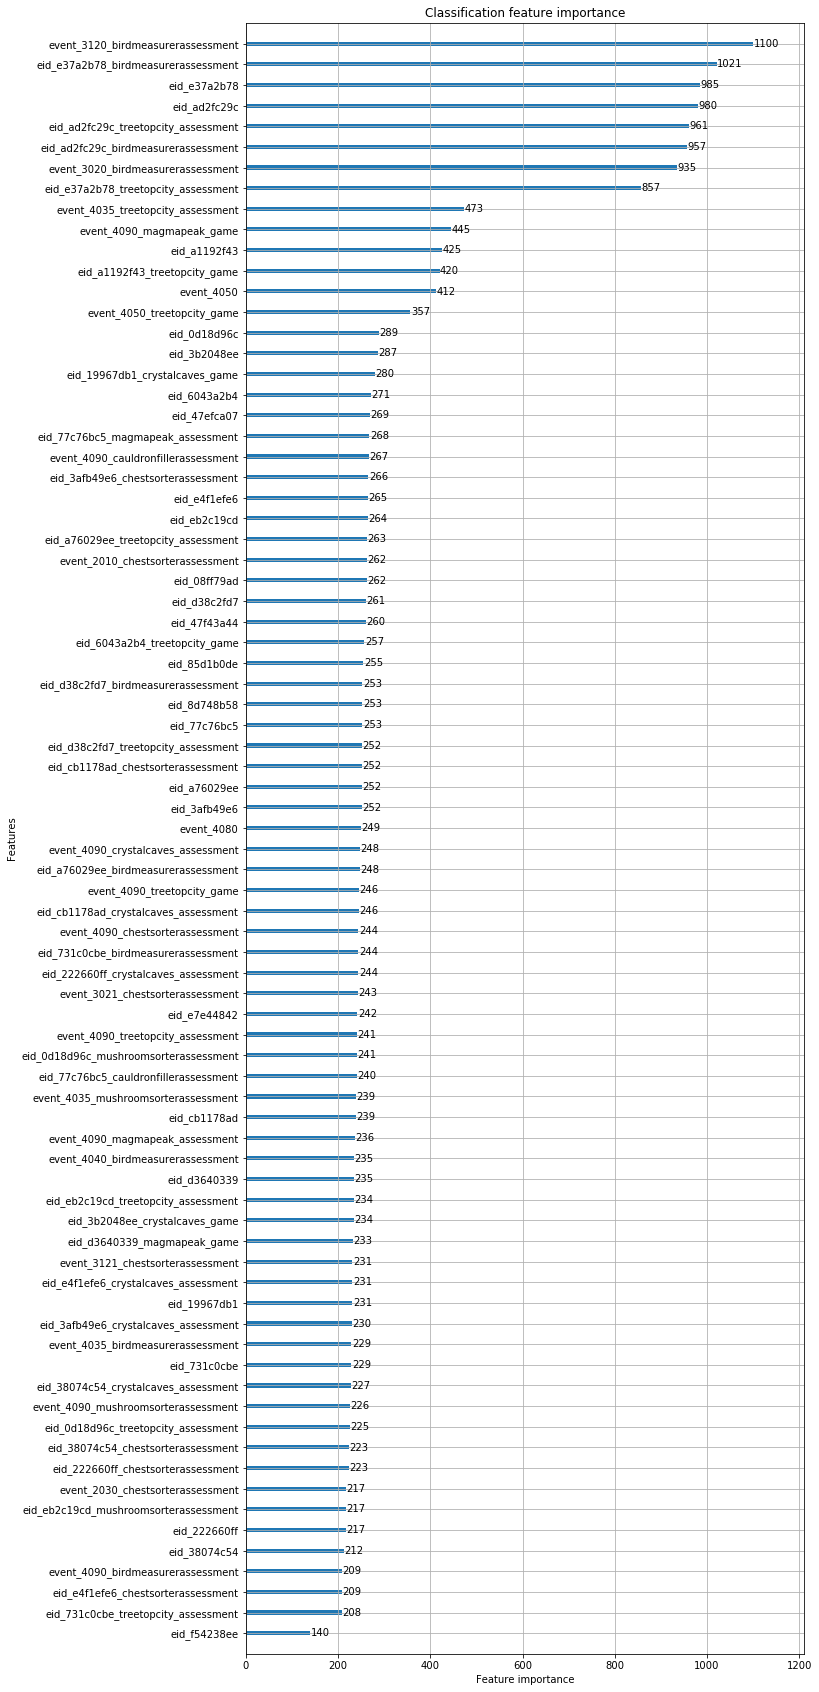

In [49]:
lgb.plot_importance(cls.best_estimator_['model'], max_num_features=100, figsize=(10, 30), title='Classification feature importance')

In [50]:
%%time
def _random_forest_classifier(x_train_cls, y_train_cls):
    model = RandomForestClassifier(n_estimators=4000, max_features='log2')
    pipe = Pipeline([('model', model)])
    param_grid = {
        'model__max_depth': [4],
        'model__min_samples_leaf': [40]
    }
    rfc = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring='f1')
    rfc.fit(x_train_cls, y_train_cls)
    assert rfc.best_estimator_['model'].n_classes_ == 2
    return rfc


#rfc = _random_forest_classifier(x_train_cls, y_train_cls)
#_log(f"""F1 RandomForestClassifier
#best_score_={rfc.best_score_:.5f}
#best_params_={rfc.best_params_}
#n_features={rfc.best_estimator_['model'].n_features_}
#""")

Wall time: 0 ns


# Regression on the number of attempts to solve the assessment

In [51]:
def _rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))


SCORING = make_scorer(_rmse, greater_is_better = False)

In [52]:
tmp = train[train['is_solved'] == 1]
y_train = tmp['solved_attempts']
x_train = tmp[PREDICTORS]
p_split = PredefinedSplit(test_fold=tmp['_is_val'].values)

split_df = tmp.groupby(['_is_val'], as_index=False)['installation_id'].count()
assert split_df.iloc[1]['installation_id'] >= 1500
split_df.head()

_is_val  installation_id
0       -1            11367
1        0             2094

In [53]:
%%time
model = lgb.LGBMRegressor(n_estimators=10000, reg_alpha=1)
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.001],
    'model__min_child_samples': [100],
    'model__colsample_bytree': [0.1]
}
cv = GridSearchCV(pipe, cv=p_split, param_grid=param_grid, scoring=SCORING)
#cv.fit(x_train, y_train, model__early_stopping_rounds=200, model__verbose=500)
cv.fit(x_train, y_train)
_log(f"""RMSE LGBMRegressor
best_score_={cv.best_score_:.5f}
best_params_={cv.best_params_}
n_features={cv.best_estimator_['model'].n_features_}
""")

RMSE LGBMRegressor
best_score_=-0.67865
best_params_={'model__colsample_bytree': 0.1, 'model__learning_rate': 0.001, 'model__min_child_samples': 100}
n_features=4167

Wall time: 12 s


In [54]:
# plot_metric only works with early stopping rounds
#lgb.plot_metric(cv.best_estimator_['model'])

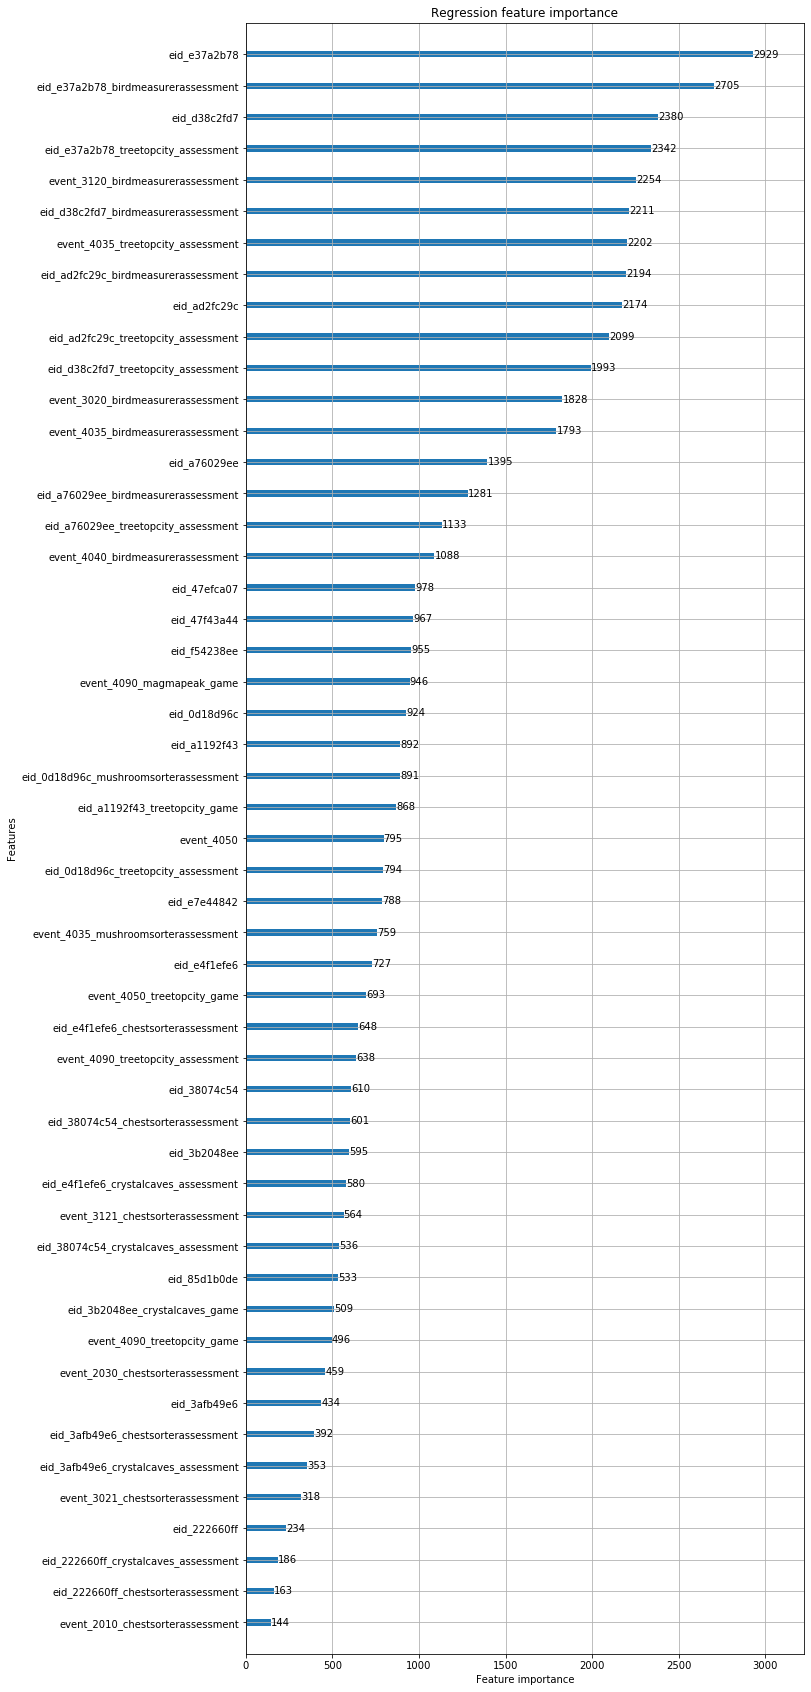

In [55]:
lgb.plot_importance(cv.best_estimator_['model'], max_num_features=100, figsize=(10, 30), title='Regression feature importance')

In [56]:
%%time
def _random_forest_regressor(x_train, y_train):
    model = RandomForestRegressor(n_estimators=4000, max_features='log2')
    pipe = Pipeline([('model', model)])
    param_grid = {
        'model__max_depth': [4],
        'model__min_samples_leaf': [40]
    }
    rfr = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
    rfr.fit(x_train, y_train)
    return rfr


#rfr = _random_forest_regressor(x_train, y_train)
#_log(f"""RMSE RandomForestRegressor
#best_score_={rfr.best_score_:.5f}
#best_params_={rfr.best_params_}
#n_features={rfr.best_estimator_['model'].n_features_}
#""")

Wall time: 0 ns


# Predict out of fold

In [57]:
%%time
def _is_solved(score):
    if score >= 0.6:
        return 1
    return 0


def _solved_attempts(score):
    if score >= 2.5:  # 1.6
        return 3
    if score >= 1.5:
        return 2
    return 1


def _predict(df, classifiers, regressors):
    res = df[['installation_id']].copy()
    res[TARGET] = np.nan
    x_cls = df[PREDICTORS]
    res['is_solved'] = 0
    for c, w, name in classifiers:
        col = f'is_solved_{name}'
        res[col] = c.predict_proba(x_cls)[:,1]
        res['is_solved'] += res[col] * w
    
    res['is_solved'] = np.int16(res['is_solved'].map(_is_solved))
    iids = set(res[res['is_solved'] == 1]['installation_id'].values)
    cols = ['installation_id'] + PREDICTORS
    tmp = df[df['installation_id'].isin(iids)][cols].copy()
    x = tmp[PREDICTORS]
    cols = ['installation_id', 'solved_attempts_raw', 'solved_attempts']
    tmp['solved_attempts_raw'] = 0
    for r, w, name in regressors:
        col = f'solved_attempts_{name}'
        cols.append(col)
        tmp[col] = r.predict(x)
        tmp['solved_attempts_raw'] += tmp[col] * w
        
    tmp['solved_attempts'] = np.int16(tmp['solved_attempts_raw'].map(_solved_attempts))
    tmp = tmp[cols]
    res = res.merge(tmp, on='installation_id', how='left')
    res.loc[res['is_solved'] == 0, [TARGET]] = 0
    res.loc[(res['is_solved'] == 1) & (res['solved_attempts'] >= 3), [TARGET]] = 1
    res.loc[(res['is_solved'] == 1) & (res['solved_attempts'] == 2), [TARGET]] = 2
    res.loc[(res['is_solved'] == 1) & (res['solved_attempts'] <= 1), [TARGET]] = 3
    assert res[TARGET].notna().all(axis=None)
    res[TARGET] = np.int16(res[TARGET])
    return res


classifiers=[
    (cls, 1, 'LGBMClassifier')
]
regressors=[
    (cv, 1, 'LGBMRegressor')
]
oof = _predict(train, classifiers=classifiers, regressors=regressors)
oof.head(10)

Wall time: 10.8 s


installation_id  accuracy_group  is_solved  is_solved_LGBMClassifier  \
0      0006a69f_1               3          1                  0.731064   
1      0006a69f_2               0          0                  0.332696   
2      0006a69f_3               3          1                  0.766697   
3      0006a69f_4               3          1                  0.766697   
4      0006a69f_5               3          1                  0.766697   
5      0006c192_1               3          1                  0.766697   
6      0006c192_2               3          1                  0.775638   
7      0006c192_3               2          1                  0.932241   
8      00129856_1               3          1                  0.766697   
9      001d0ed0_1               2          1                  0.747279   

   solved_attempts_raw  solved_attempts  solved_attempts_LGBMRegressor  
0             1.364883              1.0                       1.364883  
1                  NaN              NaN                            NaN  
2             1.349848              1.0                       1.349848  
3             1.349848              1.0                       1.349848  
4             1.349848              1.0                       1.349848  
5             1.349848              1.0                       1.349848  
6             1.353962              1.0                       1.353962  
7             2.358530              2.0                       2.358530  
8             1.349848              1.0                       1.349848  
9             1.914775              2.0                       1.914775

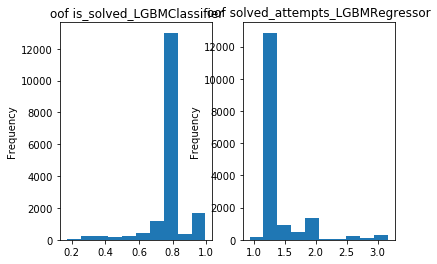

In [58]:
plt.subplot(1, 2, 1)
plt.title('oof is_solved_LGBMClassifier')
oof['is_solved_LGBMClassifier'].plot(kind='hist')
plt.subplot(1, 2, 2)
plt.title('oof solved_attempts_LGBMRegressor')
oof['solved_attempts_LGBMRegressor'].plot(kind='hist')

In [59]:
oof.sort_values(by=['installation_id'], inplace=True)
train.sort_values(by=['installation_id'], inplace=True)
score = cohen_kappa_score(oof[TARGET], train[TARGET], weights='quadratic')
_log(f'oof score={score:.5f}')

oof score=0.26879


# Predict on Test set

In [60]:
%%time
sub = _predict(test, classifiers=classifiers, regressors=regressors)
sub = sub[['installation_id', TARGET]]
sample_sub = pd.read_csv(f'{INPUT_ROOT}/sample_submission.csv')
assert sub['installation_id'].equals(sample_sub['installation_id'])
sub.head()

Wall time: 2.44 s


installation_id  accuracy_group
0        00abaee7               3
1        01242218               0
2        017c5718               3
3        01a44906               3
4        01bc6cb6               3

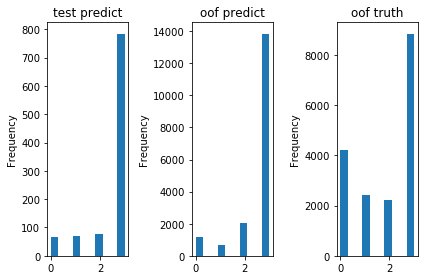

In [61]:
plt.subplot(1, 3, 1)
plt.title('test predict')
sub[TARGET].plot(kind='hist')
plt.subplot(1, 3, 2)
plt.title('oof predict')
oof[TARGET].plot(kind='hist')
plt.subplot(1, 3, 3)
plt.title('oof truth')
tmp = train[TARGET].copy()
tmp = tmp.astype(int)
tmp.plot(kind='hist')
plt.tight_layout()

In [62]:
sub.to_csv('submission.csv', index=False)
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'test_scaled.parquet', 'train.parquet', 'train_scaled.parquet']
